## Make the dataset

In [1]:
from autoencoder import *

In [2]:
theta = np.linspace(-np.pi,0.0*np.pi,500, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
dataset = tf.data.Dataset.from_tensor_slices(data)

## Train the autoencoder

In [3]:
graph = tf.Graph()
with graph.as_default():
    tr_x = atu.make_datastream(dataset)
    au = PolyAutoencoder(2,1,tr_x, 2,5)
    init=tf.global_variables_initializer()

In [4]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

In [5]:
for i in xrange(10000):
    #train_step.run(session=sess)
    sess.run(au.train_step)
    if i%1000==99:
        print au.goal.eval(session=sess)

0.028892346
3.5115165e-05
3.924023e-05
3.0457992e-05
4.1126925e-05
1.5774931e-05
1.8133567e-05
7.634246e-06
1.5350775e-05
8.887982e-06


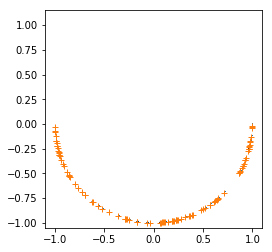

In [6]:
au.plot_distance()

In [7]:
with graph.as_default():
    # The mass matrix
    momentum = tf.constant(0.5)*tf.reduce_sum( tf.pow( au.o_x , 2 ) )
    o_M = tf.hessians( momentum, au.i_q )[0]
    o_U = au.o_x[:,1]
    o_gradU = tf.gradients( o_U, au.i_q)[0]
    o_gradX = tf.gradients(au.o_x, au.i_q)[0]

## Build the DAE

In [8]:
i_q0 = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
i_v0 = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
i_qi = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
i_vi = tf.placeholder(shape=(None,au.size_q),dtype=tf.float32)
Dt = tf.constant(0.05)
aii = 0.5
g = tf.constant(9.81)

In [9]:
def L(i_q,i_v):
    x = au.decode(i_q)
    dxdq = atu.vector_gradient(x,i_q)
    v = tf.einsum("ikj,ij->ik",dxdq,i_v)
    L = 0.5*tf.einsum("ij,ij->i",v,v) - g*x[:,1]
    return x,v, tf.expand_dims(L,-1)

In [10]:
o_x,o_v,Li = L(i_qi,i_vi)
dLi_dv = atu.vector_gradient(Li,i_vi)
dLi_dq = atu.vector_gradient(Li,i_qi)
_,_,L0 = L(i_q0,i_v0)
dL0_dv = atu.vector_gradient(L0,i_v0)
dL0_dq = atu.vector_gradient(L0,i_q0)

We use the diagonally implicit trapezoidal integrator because it's A-stable. It's tablaeu is

```
0 |  0   0
1 | 1/2 1/2
--+--------
  | 1/2 1/2
```

In [11]:
lhs = dLi_dv - Dt * aii * dLi_dq
rhs = dL0_dv + Dt * (1.0-aii) * dL0_dq
KV = atu.vector_gradient(lhs,i_vi)
KQ = atu.vector_gradient(lhs,i_qi)
Ktot = Dt*KQ + KV

In [12]:
q_i = np.array([[0.0]])
v_i = np.array([[0.0]])
q_0 = np.array([[0.0]])
v_0 = np.array([[0.0]])

## Integrate the Equations

In [13]:
theta_init = - 0.5*np.pi/2.0
x_init = np.array([[np.cos(theta_init),np.sin(theta_init)]])
qN = au.o_q.eval(feed_dict={au.i_x:x_init})
print "x_init: ",x_init, " q_init: ",qN
q_0[:] = qN[0,0]
q_i[:] = qN[0,0]
v_0[:] = 0
v_i[:] = 0
series_q, series_vq = [],[]
series_x, series_v = [], []
for it in range(1000):
    ev = lambda x : sess.run(x,feed_dict
        ={i_qi:q_i,i_q0:q_0, i_vi:v_i, i_v0:v_0})
    rhs_0 = ev(rhs)
    for k in range(10):
        K_k,lhs_k= ev(Ktot), ev(lhs)
        R = rhs_0 - lhs_k
        Dv = np.linalg.solve(K_k[0,:,:], R[0,:])
        v_i[:] += Dv
        q_i[:] = q_0 + ev(Dt)*((1.0-aii)*v_0 + aii*v_i)
        n = np.linalg.norm(Dv)
        if n<2.0e-7: break
#     print k, n, q_0
    v_0[:] = v_i[:]
    q_0[:] = q_i[:]
    series_q.append(q_0[0,0])
    series_vq.append(v_0[0,0])
    series_x.append(ev(o_x)[0,:])
    series_v.append(ev(o_v)[0,:])
series_x = np.array(series_x)
series_v = np.array(series_v)
series_q = np.array(series_q)
series_vq = np.array(series_vq)


x_init:  [[ 0.70710678 -0.70710678]]  q_init:  [[0.9262109]]


## Plot the results

In [14]:
from matplotlib import pylab as plt
%matplotlib inline

[-1, 1, -1, 0]

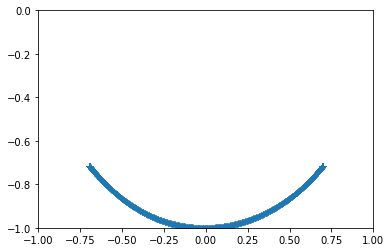

In [15]:
plt.plot(series_x[:,0],series_x[:,1], '+')
plt.axis([-1,1,-1, -0])

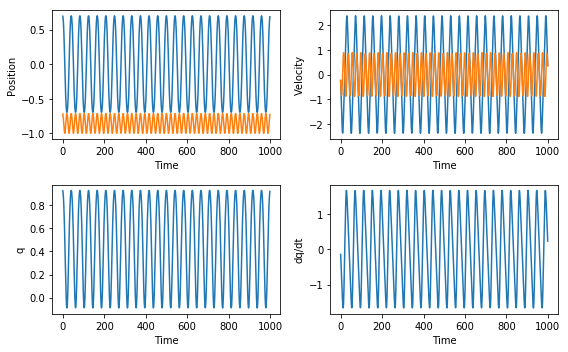

In [16]:
plt.figure(figsize=(8,5))
plt.subplot(221)
plt.plot(series_x[:,:])
plt.xlabel('Time')
plt.ylabel('Position')
plt.subplot(222)
plt.plot(series_v)
plt.xlabel('Time')
plt.ylabel('Velocity')

plt.subplot(223)
plt.plot(series_q)
plt.xlabel('Time')
plt.ylabel('q')
plt.subplot(224)
plt.plot(series_vq)
plt.ylabel('dq/dt')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('figures/pendulum_q.png',dpi=300)

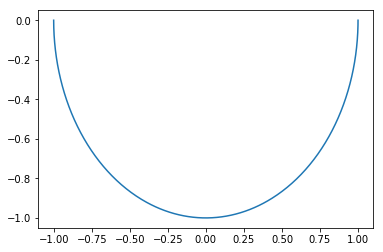

In [17]:
plt.plot(data[:,0],data[:,1])

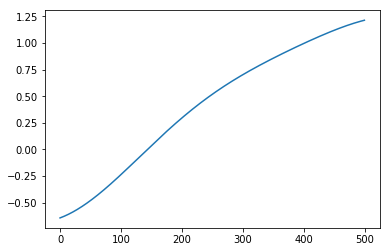

In [18]:
qN=au.o_q.eval(feed_dict={au.i_x:data})
plt.plot(qN)